In [1]:
import matplotlib.pylab as plt
import numpy as np
plt.style.use("/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle")
%config InlineBackend.figure_format = 'svg'
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
import sys
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/")
from LoadMultiFiles import LoadOneFileUproot, LoadMultiROOTFiles

from copy import copy
option_time_profile = "_NotSubtractTOF"
option = "_add_TriggerTimeInterval"
# option = ""
with np.load(f"/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/predict_Combine{option}{option_time_profile}.npz", allow_pickle=True) as f:
    dir_events = f["dir_events"].item()

In [2]:
print(dir_events.keys())


dict_keys(['evtID', 'h_time_without_charge', 'h_time_with_charge', 'XYZ', 'Erec', 'evtID_PSD', 'TriggerTimeInterval', 'evtType', 'R3', 'PSD'])


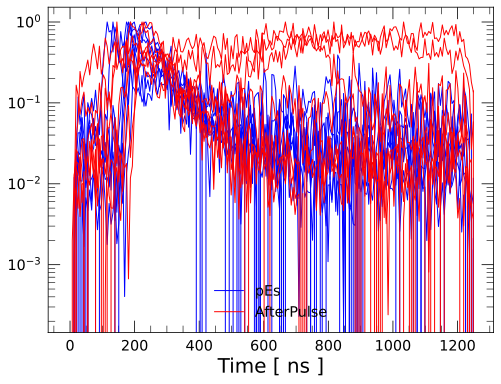

In [4]:
from PlotTools import LegendNotRepeated
from HistTools import GetBinCenter
bins = np.loadtxt(f"/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/myJUNOCommon/share/PSD/Bins_Setting{option_time_profile}.txt", delimiter=",")
v_tags = ["AfterPulse", "pEs"]
v_colors = ["red", "blue"]
# plt.figure(0)
# plt.figure(1)
for tag in [1,0]:
    for j, h_time in enumerate(dir_events["h_time_with_charge"][(dir_events["PSD"]>0.95)& (dir_events["evtType"]==tag)]) :
        # plt.figure(tag)
        plt.plot(GetBinCenter(bins), h_time/np.max(h_time), linewidth=1,label=v_tags[tag],color=v_colors[tag])
        if j > 5:
            break

    # plt.figure(tag)
    plt.semilogy()
    LegendNotRepeated()
    plt.xlabel("Time [ ns ]")

In [5]:
PSD_cut = 0.9
n_residue = len(dir_events["h_time_with_charge"][(dir_events["PSD"]>0.95)& (dir_events["evtType"]==0)])
n_total_bkg = len(dir_events["h_time_with_charge"][(dir_events["PSD"]<0.95)& (dir_events["evtType"]==0)])
ratio_residue = n_residue/n_total_bkg

print("Number of residual background:\t", n_residue)
print("Ratio:\t",  ratio_residue*100,"\t%")
print("Total:\t", n_total_bkg)

Number of residual background:	 15
Ratio:	 0.013604455005532479 	%
Total:	 110258


Text(0.5, 1.0, 'PSD Distribution(Append TriggerTimeInterval)')

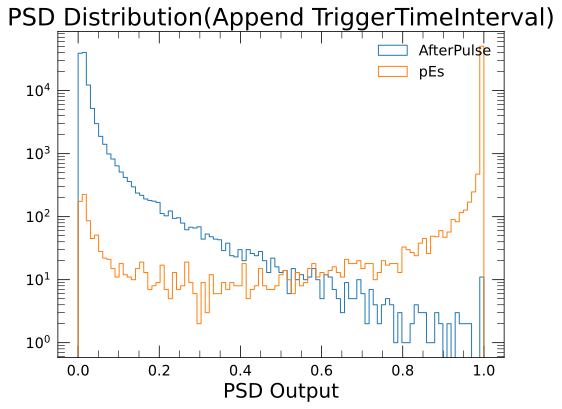

In [6]:
# print((dir_evt["recX"]**2+dir_evt["recY"]**2+dir_evt["recZ"]**2)**1.5)
# E_cut = 1.5
# R3_cut = 4096
dir_hist_PSD = {}
bins = np.linspace(0,1,100)
for i, key in enumerate([0,1]):
    dir_hist_PSD[key] = plt.hist( (dir_events["PSD"][dir_events["evtType"]==key]) ,bins=bins,
             histtype="step", label=v_tags[i])
plt.semilogy()
plt.legend()
plt.xlabel("PSD Output")
plt.title("PSD Distribution"+ ("(Append TriggerTimeInterval)" if "TriggerTimeInterval" in option else ""))
# plt.title(f"E<{E_cut} MeV & R3<{R3_cut} "+"$m^3$")

No handles with labels found to put in legend.


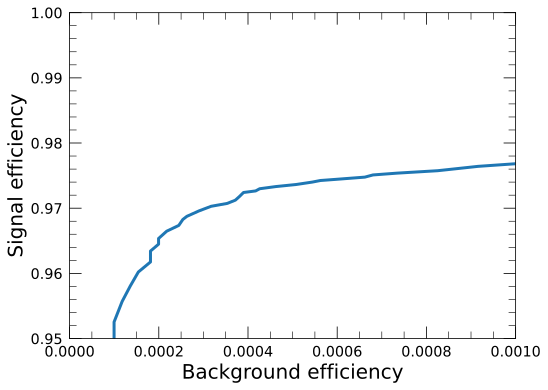

In [7]:
# Get Roc curve
n0 = dir_hist_PSD[0][0]
n1 = dir_hist_PSD[1][0]
eff_bkg = []
eff_sig = []
for i in range(len(n0)):
    eff_bkg.append(np.sum(n0[i:]) * 1.0 / np.sum(n0))
    eff_sig.append(np.sum(n1[i:]) * 1.0 / np.sum(n1))

fig2 = plt.figure("Sig eff. VS Bkg eff.")
ax2=fig2.add_subplot(111)
ax2.plot(eff_bkg, eff_sig)
# (certain_eff_bkg, eff_sig_return) = self.InterpolateToGetSigEff(v_eff_bkg=eff_bkg, v_eff_sig=eff_sig)
# ax2.scatter(certain_eff_bkg, eff_sig_return, s=20, marker=(5, 1), label=self.strategy)
# print(f"background eff. : {certain_eff_bkg} ---> signal eff. : {eff_sig_return} +- {self.GetEfficiencySigma(eff_sig_return)}")
ax2.set_xlabel('Background efficiency')
ax2.set_ylabel('Signal efficiency')
# ax2.set_title("$E_{rec}<  1.5 MeV$")
ax2.set_xlim(0, 0.001)
ax2.set_ylim(0.95, 1)
plt.legend()

Optimized Efficiency:
 Background inefficiency:	 0.255 % 
Signal efficiency:	 98.054 %


Text(0.5, 1.0, 'Efficiency Curves')

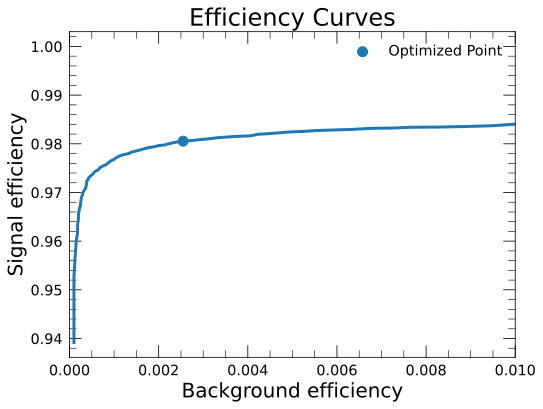

In [8]:
eff_bkg = np.array(eff_bkg)
eff_sig = np.array(eff_sig)
from scipy.interpolate import interp1d
f = interp1d(eff_bkg, eff_sig)
x = np.linspace(0.00015, 0.1, 1000)
y = f(x)
area = (1-x)*y
index_max = np.argmax(area)
print("Optimized Efficiency:\n","Background inefficiency:\t",f"{x[index_max]*100:.3f} %","\nSignal efficiency:\t", f"{y[index_max]*100:.3f} %")
plt.scatter(x[index_max], y[index_max], label="Optimized Point")
# plt.plot(x, y)
plt.plot(eff_bkg,eff_sig)
plt.xlim(0,0.01)
plt.xlabel('Background efficiency')
plt.ylabel('Signal efficiency')
plt.legend()
plt.title("Efficiency Curves")